<a href="https://colab.research.google.com/github/lucia1970-student/Autism_Repo/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import google.colab.drive
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab\ Notebooks/cours_python/FSCI2610/projet/Finale

/content/drive/MyDrive/Colab Notebooks/cours_python/FSCI2610/projet/Finale


In [8]:
import pandas as pd

df=pd.read_csv('voice_data.csv')
df.head()
print("Nombre total d'individus:", int(df.Group.count()))
df.Group.unique()

Nombre total d'individus: 108


array(['ASD', 'SLI', 'IC', 'TD'], dtype=object)

In [ ]:
#Étape Optionelle: suppression des données aberrantes.

import pandas as pd
import numpy as np

def drop_outliers_IQR(df):
    """
    Drops outliers from a DataFrame using the IQR method.

    Returns:
        pandas.DataFrame: The DataFrame with outliers removed.
    """
    # Select only numeric columns for outlier detection
    numeric_cols = df.select_dtypes(include=np.number).columns

    # Calculate quantiles and IQR only for numeric columns
    q1 = df[numeric_cols].quantile(0.25)
    q3 = df[numeric_cols].quantile(0.75)
    IQR = q3 - q1

    # Identify outliers based on numeric columns
    not_outliers = df[~((df[numeric_cols] < (q1 - 1.5 * IQR)) | (df[numeric_cols] > (q3 + 1.5 * IQR))).any(axis=1)]

    # Drop rows with missing values and reset index
    outliers_dropped = not_outliers.dropna().reset_index(drop=True)

    return outliers_dropped

df1 = df
df_outliers_dropped = drop_outliers_IQR(df1)
df = df_outliers_dropped
df_outliers_dropped

In [9]:
#On spécifie l'étude 1 ou l'étude 2
etude=2 #ou 2
ctrl_data = None

#Pour l'étude #1, on exclu le groupe 'IC' et 'SLI'
if etude == 1:
  #on exclu le groupe 'IC' et 'SLI'
  ctrl_data = df.loc[(df.Group != 'IC') & (df.Group != 'SLI')]
  print(f"Les groupes d'individus pour l'étude no. {etude} sont: {ctrl_data.Group.unique()}")
  print(f"Le nombre d'individus pour chaque type est: \n{ctrl_data.Group.value_counts()}")
else:
  #Pour l'etude #2, on inclu tous les individus
  ctrl_data = df.copy()
  print(f"Les groupes d'individus pour l'étude no. {etude} sont: {ctrl_data.Group.unique()}")
  print(f"Le nombre d'individus pour chaque type est: \n{ctrl_data.Group.value_counts()}")

#On renomme le group 'TD' à 'CTRL'
ctrl_data.loc[ctrl_data.Group == "TD", "Group"] = "CTRL"

#Pour l'étude no. 2, on doit renommer aussi le group 'IC' et 'SLI' à 'CTRL'
if etude == 2:
  #Pour l'étude #2, on renomme le group 'IC' et 'SLI'.  on a déjà renommer le groupe 'TD' ci-haut.
  ctrl_data.loc[ctrl_data.Group == "IC", "Group"] = "CTRL"
  ctrl_data.loc[ctrl_data.Group == "SLI", "Group"] = "CTRL"

y =ctrl_data["Group"]
print(f"\nLes individus du groupe pour l'étude no. {etude} sont: ", y.unique())
print(f"Le nombre d'individus pour chaque type sont: \n{ctrl_data.Group.value_counts()}")

#Pour les characteristiques, on inclus les 4 characteristiques suivante:
#print("\ctrl_data est:\n",ctrl_data)
X = ctrl_data.loc[:,['avg_F1', 'jitter_s', 'shimmer', 'mean_hnr']]

print("\nLes valeures 'y' sont:\n", y.value_counts())

print(f"\nLes valeurs de X sont:\n{X.count()}")

Les groupes d'individus pour l'étude no. 2 sont: ['ASD' 'SLI' 'IC' 'TD']
Le nombre d'individus pour chaque type est: 
Group
ASD    38
IC     25
TD     24
SLI    21
Name: count, dtype: int64

Les individus du groupe pour l'étude no. 2 sont:  ['ASD' 'CTRL']
Le nombre d'individus pour chaque type sont: 
Group
CTRL    70
ASD     38
Name: count, dtype: int64

Les valeures 'y' sont:
 Group
CTRL    70
ASD     38
Name: count, dtype: int64

Les valeurs de X sont:
avg_F1      108
jitter_s    108
shimmer     108
mean_hnr    108
dtype: int64


In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)
print("Explained variance ratio:",(sum(pca.explained_variance_ratio_)))

X_Scaled = StandardScaler().fit_transform(X_pca)

#Convertir les classes en valeures binaires.
y_numeric = y.map({'ASD':1, 'CTRL':0})
print("\nLe nombre de d'individus(es) pour chaque catégorie:\n\n",y_numeric.value_counts())

print("\nIndividus(es) autistique:", np.count_nonzero(y_numeric == 1))
print("Individus(es) non autistique:", np.count_nonzero(y_numeric == 0))

print("\nX:",len(X_Scaled), "\ny_numeric:", len(y_numeric), "\n\n")
X=X_Scaled
y=y_numeric

Explained variance ratio: 0.9999999999999999

Le nombre de d'individus(es) pour chaque catégorie:

 Group
0    70
1    38
Name: count, dtype: int64

Individus(es) autistique: 38
Individus(es) non autistique: 70

X: 108 
y_numeric: 108 




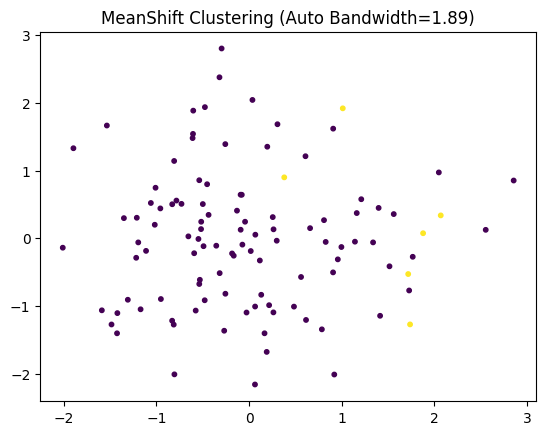

In [11]:
#Trying MeanShift clustering.

import matplotlib.pyplot as plt

from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift

# Estimate bandwidth automatically
bw_auto = estimate_bandwidth(X, quantile=0.2)

# Apply MeanShift with auto-estimated bandwidth
meanshift = MeanShift(bandwidth=bw_auto)
clusters = meanshift.fit_predict(X)

# Plot results
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap="viridis", s=10)
plt.title(f"MeanShift Clustering (Auto Bandwidth={bw_auto:.2f})")
plt.show()


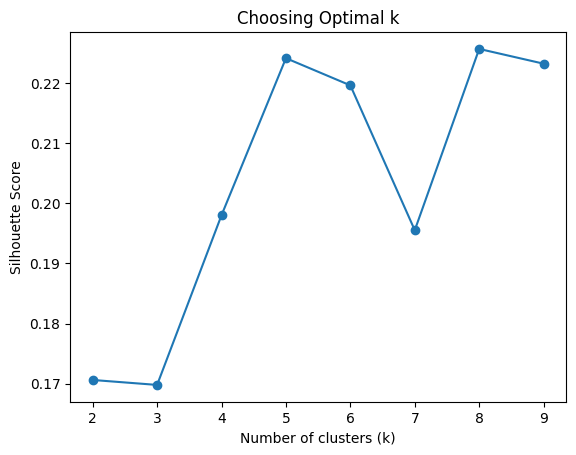

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try different values of k
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.plot(K_range, silhouette_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Choosing Optimal k")
plt.show()

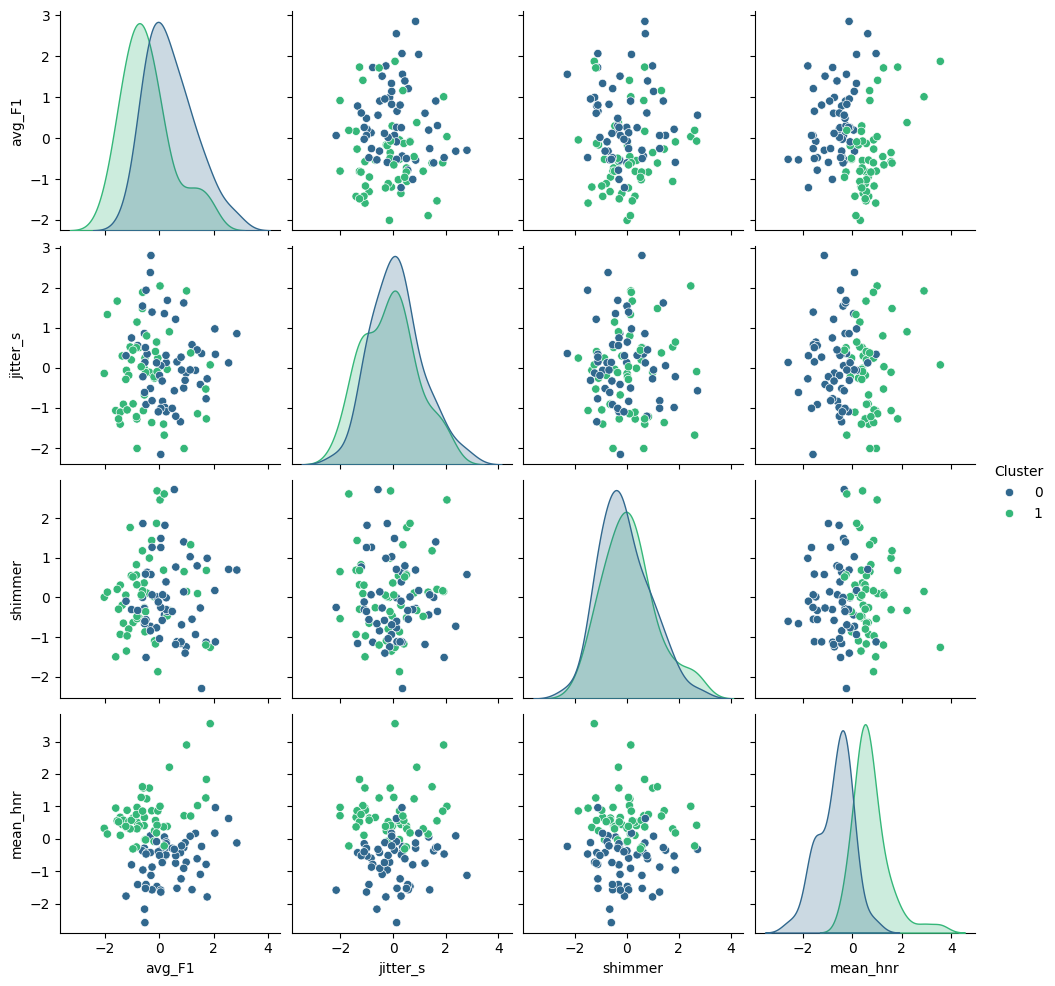

In [13]:
import seaborn as sns
import pandas as pd

df1 = pd.DataFrame(X, columns=["avg_F1", "jitter_s", "shimmer", "mean_hnr"])
df1["Cluster"] = KMeans(n_clusters=2, random_state=42).fit_predict(X)

sns.pairplot(df1, hue="Cluster", palette="viridis")
plt.show()

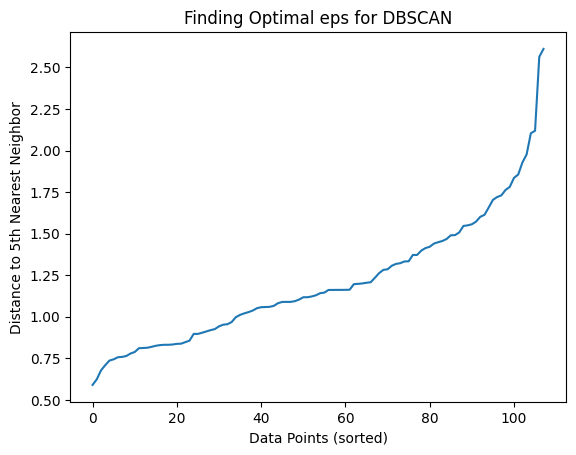

In [14]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

# Sort distances for elbow method
sorted_distances = np.sort(distances[:, 4])  # 4 because index starts at 0
plt.plot(sorted_distances)
plt.xlabel("Data Points (sorted)")
plt.ylabel("Distance to 5th Nearest Neighbor")
plt.title("Finding Optimal eps for DBSCAN")
plt.show()

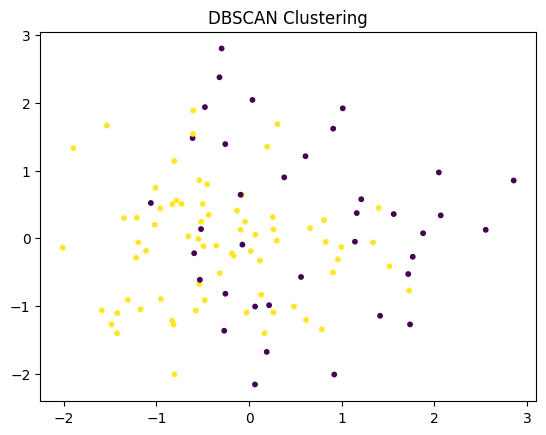

In [17]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.25, min_samples=10)
labels = dbscan.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=10)
plt.title("DBSCAN Clustering")
plt.show()

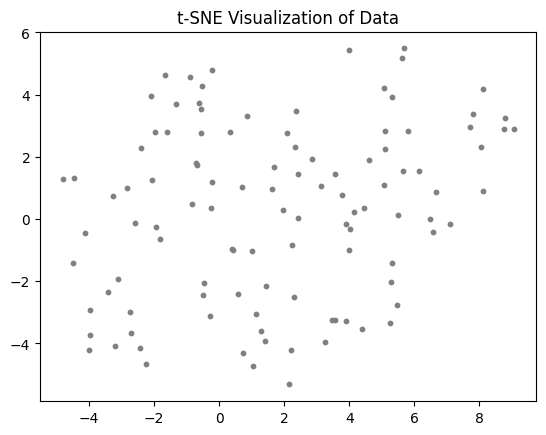

In [18]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=10, color="gray")
plt.title("t-SNE Visualization of Data")
plt.show()

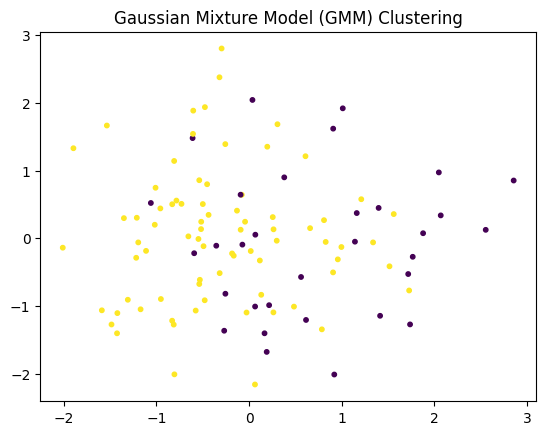

In [19]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm_labels = gmm.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap="viridis", s=10)
plt.title("Gaussian Mixture Model (GMM) Clustering")
plt.show()


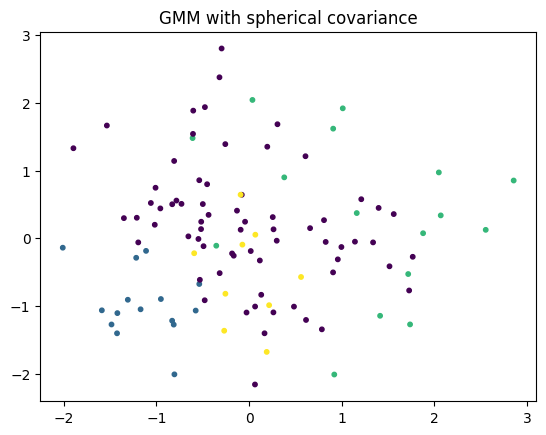

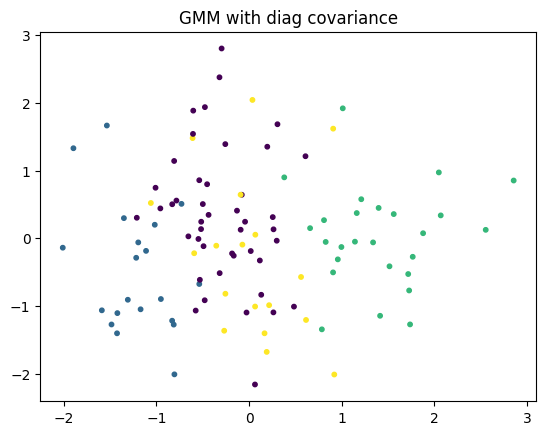

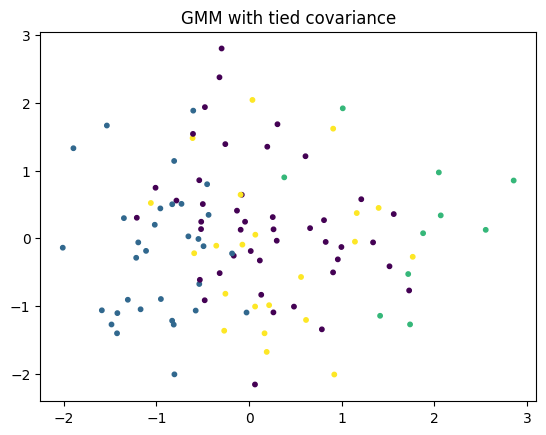

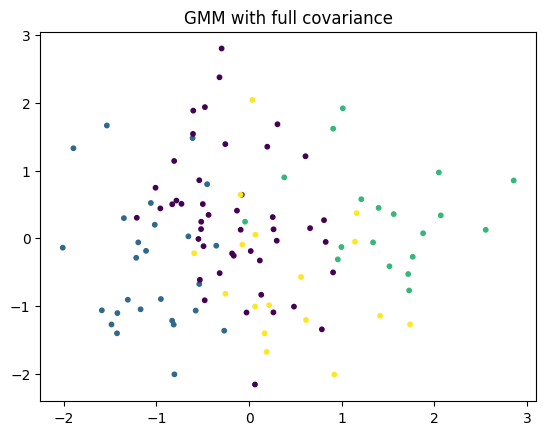

In [20]:
for cov_type in ["spherical", "diag", "tied", "full"]:
    gmm = GaussianMixture(n_components=4, covariance_type=cov_type, random_state=42)
    labels = gmm.fit_predict(X)

    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=10)
    plt.title(f"GMM with {cov_type} covariance")
    plt.show()


Type de covariance: spherical, AIC: 1239.7966156100392, BIC: 1269.3000591084055
Type de covariance: diag, AIC: 1257.6939833954752, BIC: 1303.290214256587
Type de covariance: tied, AIC: 1253.4479388770426, BIC: 1304.4084321924029
Type de covariance: full, AIC: 1238.535897527145, BIC: 1316.3177031137473

Meilleur type de covariance en se basant sur AIC: 'full'

Meilleur type de covariance en se basant sur BIC: 'spherical'


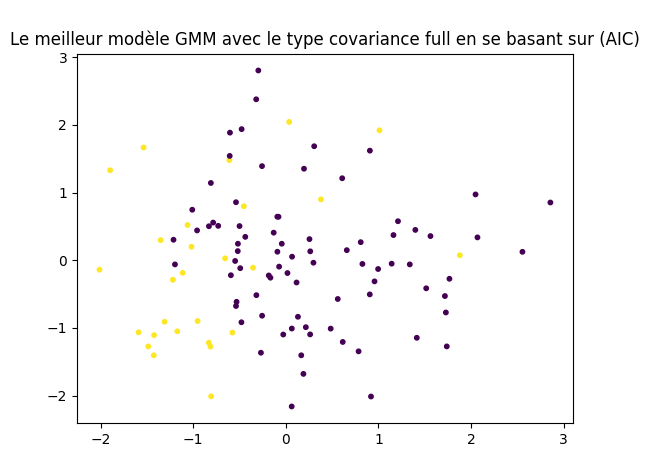

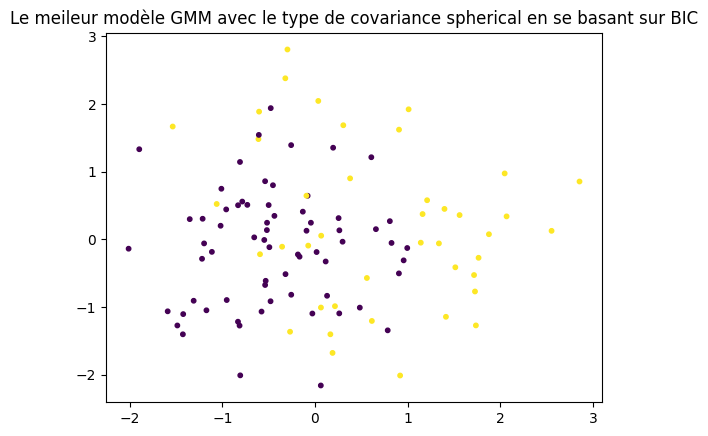

In [21]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

#X est normalisé avec StandardScaler plus haut.

best_gmm = None
best_aic = float('inf')
best_bic = float('inf')
best_cov_type_aic = ""
best_cov_type_bic = ""

covariance_types = ["spherical", "diag", "tied", "full"]

for cov_type in covariance_types:
    gmm = GaussianMixture(n_components=2, covariance_type=cov_type, random_state=42)
    gmm.fit(X)

    aic = gmm.aic(X)
    bic = gmm.bic(X)

    print(f"Type de covariance: {cov_type}, AIC: {aic}, BIC: {bic}")

    if aic < best_aic:
        best_aic = aic
        best_cov_type_aic = cov_type

    if bic < best_bic:
        best_bic = bic
        best_cov_type_bic = cov_type

print(f"\nMeilleur type de covariance en se basant sur AIC: '{best_cov_type_aic}'")
print(f"\nMeilleur type de covariance en se basant sur BIC: '{best_cov_type_bic}'")

# Visualiser les meilleures modèles baser sur AIC et BIC, respectivement.
best_gmm_aic = GaussianMixture(n_components=2, covariance_type=best_cov_type_aic, random_state=42)
labels_aic = best_gmm_aic.fit_predict(X)

best_gmm_bic = GaussianMixture(n_components=2, covariance_type=best_cov_type_bic, random_state=42)
labels_bic = best_gmm_bic.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels_aic, cmap="viridis", s=10)
plt.title(f"\nLe meilleur modèle GMM avec le type covariance {best_cov_type_aic} en se basant sur (AIC)")
plt.show()

plt.scatter(X[:, 0], X[:, 1], c=labels_bic, cmap="viridis", s=10)
plt.title(f"Le meileur modèle GMM avec le type de covariance {best_cov_type_bic} en se basant sur BIC")
plt.show()



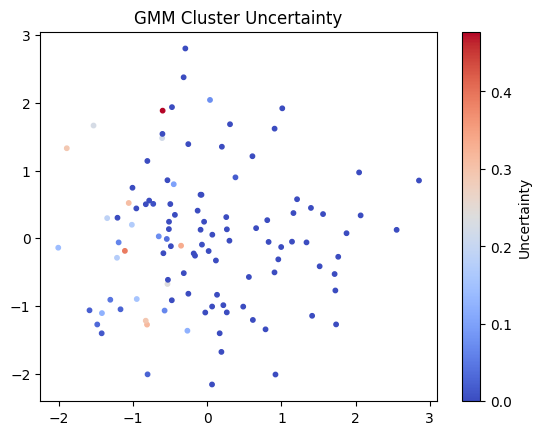

In [23]:
import numpy as np

gmm_probs = gmm.predict_proba(X)  # Probabilities for each cluster
uncertainty = 1 - np.max(gmm_probs, axis=1)  # Higher means less confidence

plt.scatter(X[:, 0], X[:, 1], c=uncertainty, cmap="coolwarm", s=10)
plt.colorbar(label="Uncertainty")
plt.title("GMM Cluster Uncertainty")
plt.show()


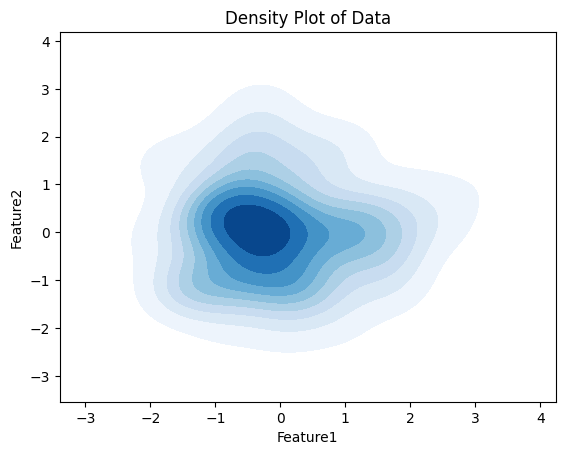

In [24]:
import seaborn as sns
import pandas as pd

# Create a DataFrame from your data
df_kde = pd.DataFrame(X, columns=['Feature1', 'Feature2', 'Feature3', 'Feature4'])

# Create a density plot using seaborn.kdeplot
sns.kdeplot(data=df_kde, x='Feature1', y='Feature2', cmap="Blues", fill=True)
plt.title("Density Plot of Data")
plt.show()

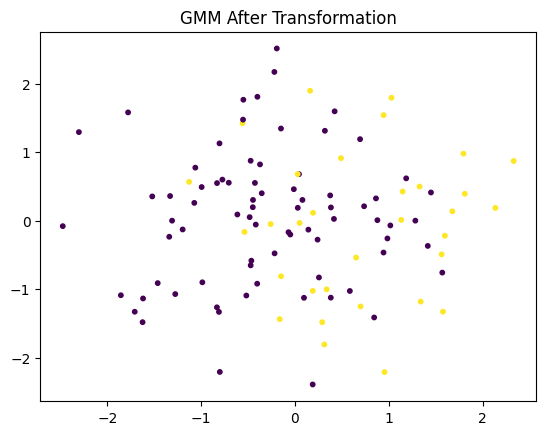

In [25]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method="yeo-johnson")
X_transformed = pt.fit_transform(X)

gmm = GaussianMixture(n_components=2, random_state=42)
labels = gmm.fit_predict(X_transformed)

plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=labels, cmap="viridis", s=10)
plt.title("GMM After Transformation")
plt.show()


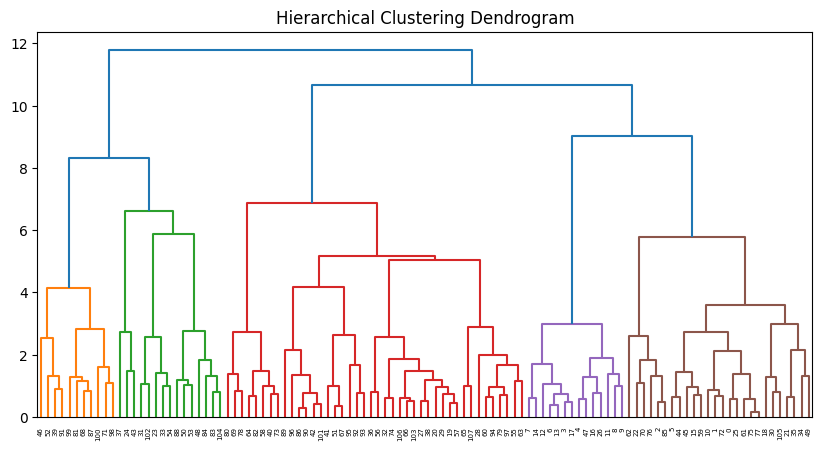

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X, method="ward")  # Ward method helps with compact clusters
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


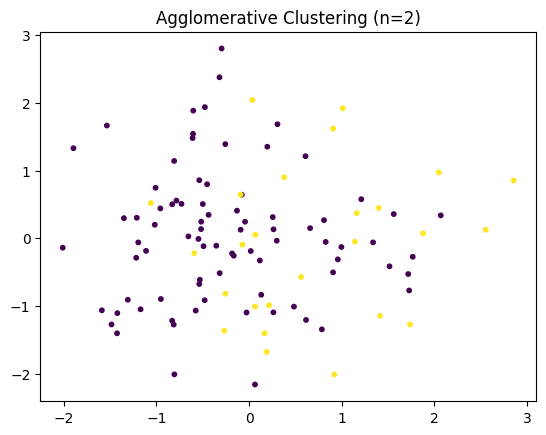

Silhouette Score for Hierarchical Clustering: 0.228


In [27]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=2, linkage="ward")
labels = agg_clustering.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=10)
plt.title("Agglomerative Clustering (n=2)")
plt.show()

from sklearn.metrics import silhouette_score

score = silhouette_score(X, labels)
print(f"Silhouette Score for Hierarchical Clustering: {score:.3f}")


In [28]:
for method in ["ward", "complete", "average", "single"]:
    agg_clustering = AgglomerativeClustering(n_clusters=2, linkage=method)
    labels = agg_clustering.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f"Linkage={method}, Silhouette Score={score:.3f}")


Linkage=ward, Silhouette Score=0.228
Linkage=complete, Silhouette Score=0.331
Linkage=average, Silhouette Score=0.331
Linkage=single, Silhouette Score=0.404


In [29]:
for k in [2, 3, 4, 6, 7, 8]:  # Adjust based on dendrogram insights
    agg_clustering = AgglomerativeClustering(n_clusters=k, linkage="single")
    labels = agg_clustering.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f"Clusters={k}, Silhouette Score={score:.3f}")


Clusters=2, Silhouette Score=0.404
Clusters=3, Silhouette Score=0.245
Clusters=4, Silhouette Score=0.156
Clusters=6, Silhouette Score=0.077
Clusters=7, Silhouette Score=0.025
Clusters=8, Silhouette Score=-0.043


In [32]:
!pip install scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.3 MB/s eta 0:00:00


silhouette_score: 0.17560473060210877


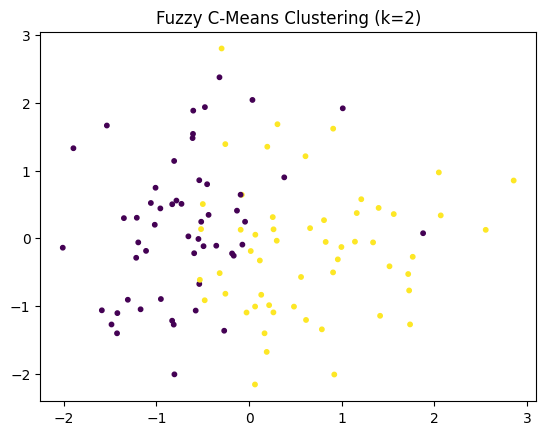

In [41]:
import skfuzzy as fuzz
import numpy as np
import matplotlib.pyplot as plt

# Choose the number of clusters
n_clusters = 2  # Based on your findings with Agglomerative Clustering

# Apply Fuzzy C-Means
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(X.T, n_clusters, m=2, error=0.005, maxiter=1000, init=None)

# Find the highest membership value for each data point (assign cluster based on max membership)
labels = np.argmax(u, axis=0)

score = silhouette_score(X, labels)
print("silhouette_score:", score)

# Visualize the clustering result
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=10)
plt.title("Fuzzy C-Means Clustering (k=2)")
plt.show()


In [45]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

In [55]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
import numpy as np
import skfuzzy  # import the library
from skfuzzy.cluster import cmeans  # Import the module

# Define hyperparameter grid
param_grid = {"n_clusters": [2, 3, 4], "m": [1.5, 2, 2.5]}

results = []

# Perform grid search
for params in ParameterGrid(param_grid):
    # Use cmeans directly with the desired parameters
    cntr, u, u0, d, jm, p, fpc = cmeans(
        X_train.T, params["n_clusters"], params["m"], error=0.005, maxiter=1000
    )

    # Predict membership on validation data
    # Instead of using cmeans with init=cntr, calculate memberships directly:
    u_pred, _, _, _, _, _ = fuzz.cluster.cmeans_predict(
        X_val.T, cntr, params["m"], error=0.005, maxiter=1000
    )
    y_pred = np.argmax(u_pred, axis=0)  # Assign cluster based on maximum membership

    # Evaluate clustering performance
    silhouette = silhouette_score(X_val, y_pred)
    davies_bouldin = davies_bouldin_score(X_val, y_pred)
    calinski_harabasz = calinski_harabasz_score(X_val, y_pred)

    results.append(
        {
            "n_clusters": params["n_clusters"],
            "m": params["m"],
            "silhouette_score": silhouette,
            "davies_bouldin_score": davies_bouldin,
            "calinski_harabasz_score": calinski_harabasz,
        }
    )

print("Hyperparamater Search Results:")
for result in results:
  print(result)

Hyperparamater Search Results:
{'n_clusters': 2, 'm': 1.5, 'silhouette_score': np.float64(0.10383960829789461), 'davies_bouldin_score': np.float64(2.0006337583121114), 'calinski_harabasz_score': np.float64(3.5825548532957034)}
{'n_clusters': 3, 'm': 1.5, 'silhouette_score': np.float64(0.12894325057769382), 'davies_bouldin_score': np.float64(1.6041141866059732), 'calinski_harabasz_score': np.float64(4.386051635222731)}
{'n_clusters': 4, 'm': 1.5, 'silhouette_score': np.float64(0.09445506664849806), 'davies_bouldin_score': np.float64(1.415118848455598), 'calinski_harabasz_score': np.float64(4.445972000857926)}
{'n_clusters': 2, 'm': 2, 'silhouette_score': np.float64(0.10383960829789461), 'davies_bouldin_score': np.float64(2.0006337583121114), 'calinski_harabasz_score': np.float64(3.5825548532957034)}
{'n_clusters': 3, 'm': 2, 'silhouette_score': np.float64(0.16096590969217078), 'davies_bouldin_score': np.float64(1.57487730005985), 'calinski_harabasz_score': np.float64(5.014948668666)}
{'

In [63]:
#KMeans++ clustering only (Baseline).

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # Make sure to import

accuracy_scores = []

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

for i in range(10):
  # Train a KMeqns++ (baseline)
  clf = KMeans(n_clusters=2, init="k-means++")
  clf.fit(X_train, y_train)
  accuracy_scores.append(accuracy_score(y_train, clf.predict(X_train)))
  silhouette_scores.append(silhouette_score(X_train, clf.predict(X_train)))

y_pred_baseline = clf.predict(X_train)  # Store baseline predictions
accuracy_baseline = accuracy_score(y_train, y_pred_baseline)


# Use a different variable name to store the calculated silhouette score
current_silhouette_score = silhouette_score(X_train, y_pred_baseline)
print(f"Means Baseline Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Means Silhouette score is: {np.mean(silhouette_scores)}")

Means Baseline Accuracy: 0.5347
Means Silhouette score is: 0.193122841816997


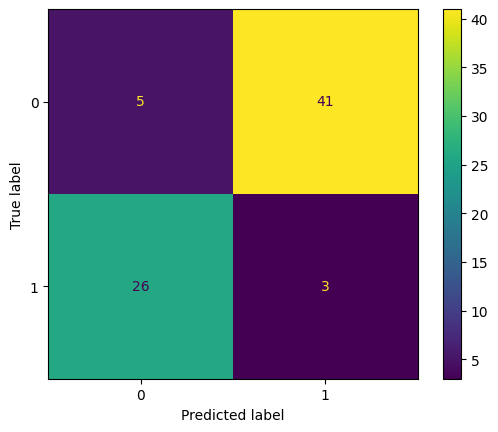

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_pred_baseline)

display=ConfusionMatrixDisplay(cm)
display.plot()


In [84]:
#SVC classification only (Baseline)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.3)

# Train a SVC classifier (baseline)
clf = SVC(probability=True, kernel="linear")
clf.fit(X_train, y_train)

y_pred_baseline = clf.predict(X_train)
accuracy_baseline = accuracy_score(y_train, y_pred_baseline)

print(f"Baseline Accuracy (No Clustering): {accuracy_baseline:.4f}")

Baseline Accuracy (No Clustering): 0.8400


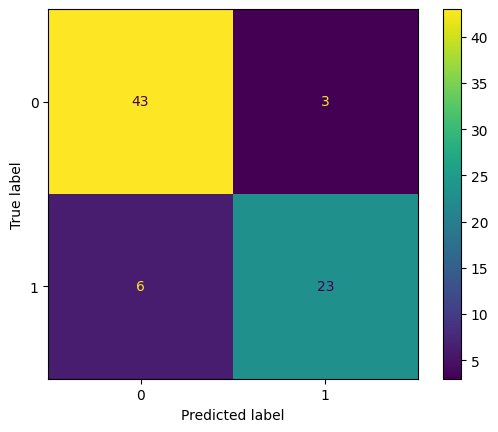

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_pred_baseline)

display=ConfusionMatrixDisplay(cm)
display.plot()
